<a href="https://colab.research.google.com/github/jgamel/learn_n_dev/blob/python_ds_examples/time_series_forecasting_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A [time series](https://en.wikipedia.org/wiki/Time_series) is a succession of chronologically ordered data spaced at equal or unequal intervals. The [forecasting](https://en.wikipedia.org/wiki/Forecasting#Time_series_methods) process consists of predicting the future value of a time series, either by modeling the series solely based on its past behavior (autoregressive) or by using other external variables.

This document describes how to use Scikit-learn regression models to perform forecasting on time series. Specifically, it introduces [Skforecast](https://joaquinamatrodrigo.github.io/skforecast/0.4.2/index.html), a simple library that contains the classes and functions necessary to adapt any Scikit-learn regression model to forecasting problems. 

### Multi-Step Time Series Forecasting

The common objective of working with time series is not only to predict the next element in the series ( 𝑡+1 ) but an entire future interval or a point far away in time ( 𝑡+𝑛 ). Each prediction jump is known as a step.

There are several strategies that allow generating this type of multiple prediction.


Recursive multi-step forecasting

Since to predict the moment  𝑡𝑛  the value of  𝑡𝑛−1  is needed, which is unknown, it is necessary to make recursive predictions. New predictions use previous ones as predictors. This process is known as recursive forecasting or recursive multi-step forecasting.

The main adaptation needed to apply Scikit-learn models to recursive multi-step forecasting problems is to transform the time series into a matrix in which each value is associated with the time window (lags) preceding it. This forecasting strategy can be easily generated with the ForecasterAutoreg and ForecasterAutoregCustom classes from the Skforecast library.

Transformation of a time series into a 5 lags matrix and a vector with the value of the series that follows each row of the matrix.
This type of transformation also allows the inclusion of exogenous variables to the time series.

Direct multi-step forecasting

The direct multi-step forecasting method consists of training a different model for each step. For example, to predict the following 5 values of a time series, 5 different models are required to be trained, one for each step. As a result, the predictions are independent of each other.

The main complexity of this approach is to generate the correct training matrices for each model. The ForecasterAutoregMultiOutput class of the Skforecast library automates this process. It is also important to bear in mind that this strategy has a higher computational cost since it requires the train of multiple models. The following diagram shows the process for a case in which the response variable and two exogenous variables are available.

Multiple output forecasting

Certain models are capable of simultaneously predicting several values of a sequence (one-shot). An example of a model with this capability is the LSTM neural network.


### Recursive autoregressive forecasting

A time series is available with the monthly expenditure (millions of dollars) on corticosteroid drugs that the Australian health system had between 1991 and 2008. It is intended to create an autoregressive model capable of predicting future monthly expenditures.

Load Modules:

In [ ]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

Mount Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Load skforecast

In [ ]:
# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

import session_info


### Get Data

The data used in the examples of this document have been obtained from the magnificent book Forecasting: [Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [ ]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')
data.head()

,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199


### Data Prep

The column date has been stored as a string. To convert it to datetime the pd.to_datetime() function can be use. Once in datetime format, and to make use of pandas functionalities, it is set as an index. Also, since the data is monthly, the frequency is set as Monthly Started 'MS'.

In [ ]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.379808,0.958792,1.166029
1992-05-01,0.361801,0.951993,1.117859
1992-06-01,0.410534,0.952955,1.067942
1992-07-01,0.483389,0.958078,1.097376
1992-08-01,0.475463,0.956370,1.122199


The time series is verified to be complete.

In [ ]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

If False:

In [ ]:
# Fill gaps in a temporary index
# ==============================================================================
# data.asfreq(freq='30min', fill_value=np.nan)

The last 36 months are used as the test set to evaluate the predictive capacity of the model.

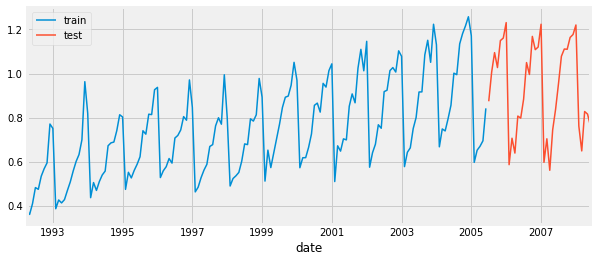

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg

With the ForecasterAutoreg class, a model is created and trained from a RandomForestRegressor regressor with a time window of 6 lags. This means that the model uses the previous 6 months as predictors.

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=data_train['y'])

forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-02-20 17:50:01 
Last fit date: 2022-02-20 17:50:02 
Skforecast version: 0.4.3.dev2 

Once the model is trained, the test data is predicted (36 months into the future).

In [ ]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

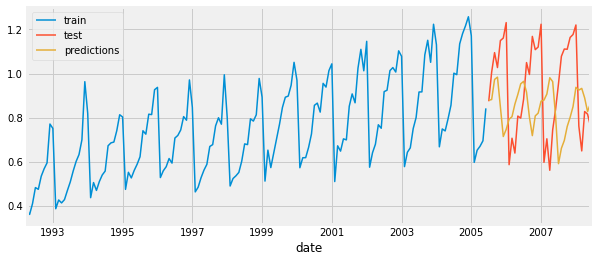

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

The error that the model makes in its predictions is quantified. In this case, the metric used is the mean squared error (mse).

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.07326833976120374


### Hyperparameter tuning

The trained ForecasterAutoreg uses a 6 lag time window and a Random Forest model with the default hyperparameters. However, there is no reason why these values are the most suitable.

In order to identify the best combination of lags and hyperparameters, Skforecast has the grid_search_forecaster function. This function uses backtesting to compare the performance obtained with each configuration of the model. It is important not to include the test data in the search process to avoid overfitting problems.

In this example, for the first fold, the initial 50% of the observations are the training data and, the next 10 steps represent the validation set. In successive folds, the training set will contain all data used in the previous fold and, the next 10 steps will be used as new validation data. This process will be repeated until the entire training data set is used.

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

# Lags used as predictors
lags_grid = [10, 20]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 10,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [01:12<00:00, 36.31s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.008055003809735634



In [ ]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,max_depth,n_estimators
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.008055,3,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.008220,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",0.008326,5,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",0.008330,5,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",0.008336,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.008359,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",0.028249,10,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",0.028386,5,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",0.028830,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",0.028883,3,100


The best results are obtained using a time window of 20 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 500}.

### Final model

Finally, a ForecasterAutoreg is trained with the optimal configuration found by validation. This step is not necessary if return_best = True is specified in the grid_search_forecaster() function.

In [ ]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)

forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=data_train['y'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

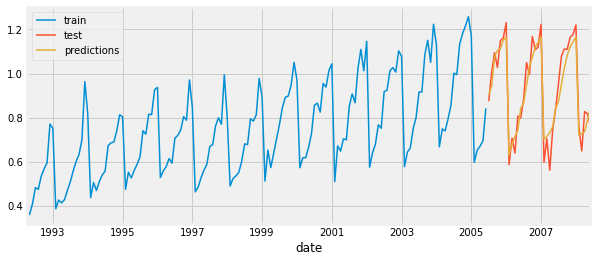

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.004392699665157793


The optimal combination of hyperparameters significantly reduces test error.

### Backtesting


The Backtesting process consists of simulating the behavior that the model would have had if it had been run on a recurring basis, for example, predicting at intervals of 3 years (36 months) a total of 9 years. This type of evaluation can be easily applied with the backtesting_forecaster() function.

**Backtesting with refit**

The model is trained each tieme before making the predictions, in this way, the model use all the information available so far. It is a variation of the standar cross-validation but, instead of making a random distribution of the observations, the training set is increased sequentially, maintaining the temporal order of the data.

**Backtesting without refit**

After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is only trained once. However, the model does not incorporate the latest information available so it may lose predictive capacity over time.

In [ ]:
# Backtesting
# ==============================================================================
n_test = 36*3 # The last 9 years are separated for the backtest
data_train = data[:-n_test]
data_test  = data[-n_test:]

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    initial_train_size = len(data_train),
                                    steps      = steps,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

print(f"Backtest error: {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00

Backtest error: [0.01057898]


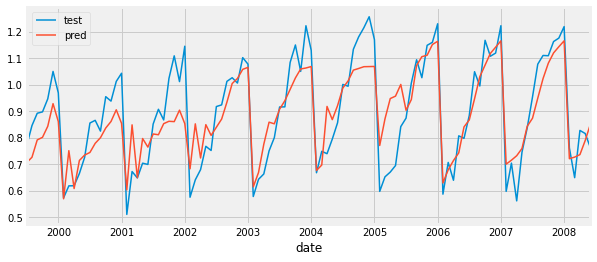

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
data_test['y'].plot(ax=ax, label='test')
predictions_backtest.plot(ax=ax, label='predictions')
ax.legend();

### Predictors importance

Since the ForecasterAutoreg object uses Scikit-learn models, the importance of predictors can be accessed once trained. When the regressor used is a LinearRegression(), Lasso() or Ridge(), the coefficients of the model reflect their importance, obtained with the get_coef() method. In GradientBoostingRegressor() or RandomForestRegressor() regressors, the importance of predictors is based on impurity reduction and is accessible through the get_feature_importance() method. In both cases, the values returned are sorted as the lags order.

In [ ]:
# Predictors importance
# ==============================================================================
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.009412
1,lag_2,0.087268
2,lag_3,0.012754
3,lag_4,0.001446
4,lag_5,0.000401
5,lag_6,0.001386
6,lag_7,0.001273
7,lag_8,0.006926
8,lag_9,0.005839
9,lag_10,0.013076


### Recursive autoregressive forecasting with exogenous variables

In the previous example, only lags of the predicted variable itself have been used as predictors. In certain scenarios, it is possible to have information about other variables, whose future value is known, so could serve as additional predictors in the model.

Continuing with the previous example, a new variable whose behavior is correlated with the modeled time series and it is wanted to incorporate as a predictor is simulated. The same applies to multiple exogenous variables.

### Get Data

In [ ]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

### Data Prep

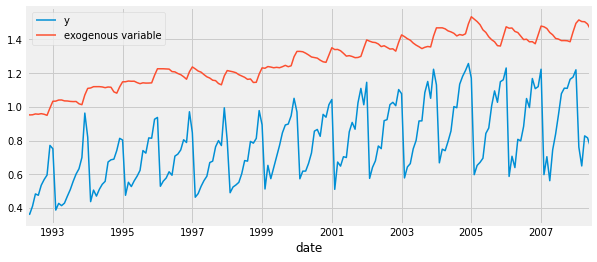

In [ ]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

fig, ax = plt.subplots(figsize=(9, 4))
data['y'].plot(ax=ax, label='y')
data['exog_1'].plot(ax=ax, label='exogenous variable')
ax.legend();

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

### ForecasterAutoreg

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=data_train['y'], exog=data_train['exog_1'])

### Predictions

If the ForecasterAutoreg is trained with an exogenous variable, the value of this variable must be passed to predict(). It is only applicable to scenarios in which future information on the exogenous variable is available.

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

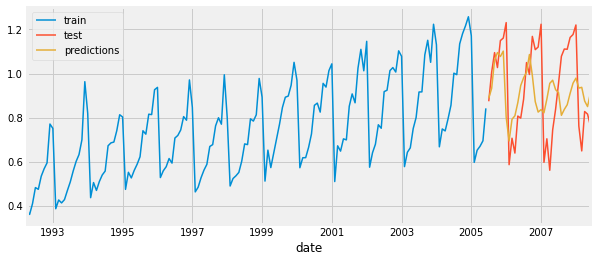

In [ ]:
# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.03989087922533575


### Hyperparameter tuning

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        exog        = data_train['exog_1'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 27


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:57<00:00, 39.30s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 0.007814854588045633



In [ ]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,metric,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 3, 'n_estimators': 50}",0.007815,3,50
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'max_depth': 5, 'n_estimators': 50}",0.007940,5,50
20,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",0.007944,3,500
19,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",0.008057,3,100
25,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",0.008106,10,100


The best results are obtained using a time window of 12 lags and a Random Forest set up of {'max_depth': 3, 'n_estimators': 50}.

### Final model

Setting return_best = True in grid_search_forecaster(), after the search, the ForecasterAutoreg object has been modified and trained with the best configuration found.

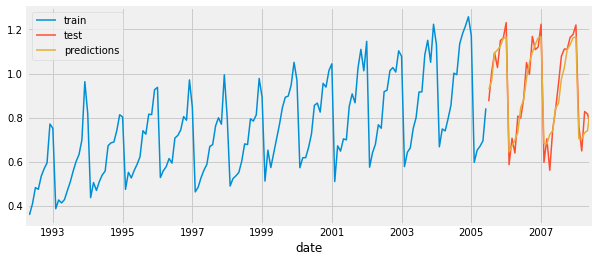

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps, exog=data_test['exog_1'])

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.003965444559763559


### Recursive autoregressive forecasting with custom predictors

In addition to the lags, it may be interesting to incorporate other characteristics of the time series in some scenarios. For example, the moving average of the last n values could be used to capture the series's trend.

The ForecasterAutoregCustom class behaves very similar to the ForecasterAutoreg class seen in the previous sections, but with the difference that it is the user who defines the function used to create the predictors.

The first example of the document about predicting the last 36 months of the time series is repeated. In this case, the predictors are the first 10 lags and the values' moving average of the lasts 20 months.

### Get Data:

In [ ]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data = pd.read_csv(url, sep=',')

### Prep Data:

In [ ]:
# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

### Data Split

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

### ForecasterAutoregCustom

A ForecasterAutoregCustom is created and trained from a RandomForestRegressor regressor. The create_predictor() function, which calculates the first 10 lags and the moving average of the last 20 values, is used to create the predictors.

In [ ]:
# Function to calculate predictors from time series
# ==============================================================================
def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors

When creating the forecaster, the window_size argument must be equal to or greater than the window used by the function that creates the predictors. This value, in this case, is 20.

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

forecaster.fit(y=data_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Window size: 20 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-02-20 17:53:28 
Last fit date: 2022-02-20 17:53:28 
Skforecast version: 0.4.3.dev2 

It is possible to access the custom function used to create the predictors.

In [ ]:
print(forecaster.source_code_create_predictors)

def custom_predictors(y):
    '''
    Create first 10 lags of a time series.
    Calculate moving average with window 20.
    '''
    
    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])
    
    return predictors



Using the method create_train_X_y, is it posible to acces the matrices that are created internally in the training process.

In [ ]:
X, y = forecaster.create_train_X_y(y=data_train['y'])
X.head(4)

,custom_predictor_0,custom_predictor_1,custom_predictor_2,custom_predictor_3,custom_predictor_4,custom_predictor_5,custom_predictor_6,custom_predictor_7,custom_predictor_8,custom_predictor_9,custom_predictor_10
date,,,,,,,,,,,
1993-12-01,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.387554,0.523089
1994-01-01,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.427283,0.552253
1994-02-01,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.413890,0.575129
1994-03-01,0.437670,0.819325,0.963081,0.699605,0.632947,0.601514,0.558443,0.509210,0.470126,0.428859,0.576486


In [ ]:
y.head(4)

date
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
Freq: MS, Name: y, dtype: float64

### Predictions

In [ ]:
# Predictions
# ==============================================================================
steps = 36
predictions = forecaster.predict(steps=steps)

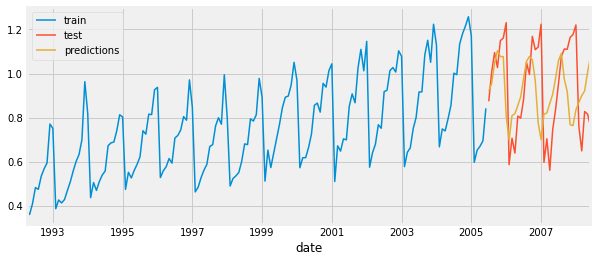

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

### Prediction error in the test set

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.046232546768232


### Hyperparameter tuning

When using the grid_search_forecaster() function with a ForecasterAutoregCustom, thelags_grid argument is not specified.

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        param_grid  = param_grid,
                        steps       = 10,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 6


loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:35<00:00, 35.08s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: custom predictors 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 0.0280647200742407



In [ ]:
# Grid Search results
# ==============================================================================
results_grid


,lags,params,metric,max_depth,n_estimators
4,custom predictors,"{'max_depth': 10, 'n_estimators': 100}",0.028065,10,100
5,custom predictors,"{'max_depth': 10, 'n_estimators': 500}",0.028362,10,500
3,custom predictors,"{'max_depth': 5, 'n_estimators': 500}",0.028834,5,500
2,custom predictors,"{'max_depth': 5, 'n_estimators': 100}",0.028935,5,100
1,custom predictors,"{'max_depth': 3, 'n_estimators': 500}",0.031041,3,500
0,custom predictors,"{'max_depth': 3, 'n_estimators': 100}",0.031537,3,100


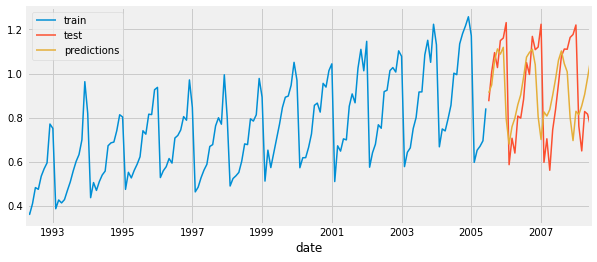

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.04303681771042639


### Direct multi-step forecasting

The ForecasterAutoreg and ForecasterAutoregCustom models follow a recursive prediction strategy in which each new prediction builds on the previous one. An alternative is to train a model for each of the steps to be predicted. This strategy, commonly known as direct multi-step forecasting, is computationally more expensive than recursive since it requires training several models. However, in some scenarios, it achieves better results. These kinds of models can be obtained with the ForecasterAutoregMultiOutput class and can include one or multiple exogenous variables.

### ForecasterAutoregMultiOutput

Unlike when using ForecasterAutoreg or ForecasterAutoregCustom, the number of steps to be predicted must be indicated in the ForecasterAutoregMultiOutput type models. This means that the number of predictions obtained when executing the predict() method is always the same.

In [ ]:
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=123)),
                    steps     = 36,
                    lags      = 8
                )
forecaster

ForecasterAutoregMultiOutput 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(random_state=123))]) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Maximum steps predicted: 36 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'lasso__alpha': 1.0, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__normalize': 'deprecated', 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 123, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False} 
Creation date: 2022-02-20 17:54:05 
Last fit date: None 
Skforecast version: 0.4.3.dev2 

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
# To access parameters of a scikitlearn pipeline the pattern:
# <name of the step>__<name of the parameter>.
param_grid = {'lasso__alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['y'],
                        param_grid  = param_grid,
                        lags_grid = lags_grid,
                        steps       = 36,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        return_best = True,
                        verbose     = False
                    )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:14<00:00,  4.78s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'lasso__alpha': 0.021544346900318846}
  Backtesting metric: 0.010608155083112462



In [ ]:
# Grid Search results
# ==============================================================================
results_grid.head()

,lags,params,metric,lasso__alpha
23,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'lasso__alpha': 0.021544346900318846},0.010608,0.021544
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.021544346900318846},0.012005,0.021544
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.0016681005372000592},0.013960,0.001668
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 0.0001291549665014884},0.014614,0.000129
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",{'lasso__alpha': 1e-05},0.014648,0.000010


The best results are obtained using a time window of 20 lags and a Lasso setting {'alpha': 0.0215}.

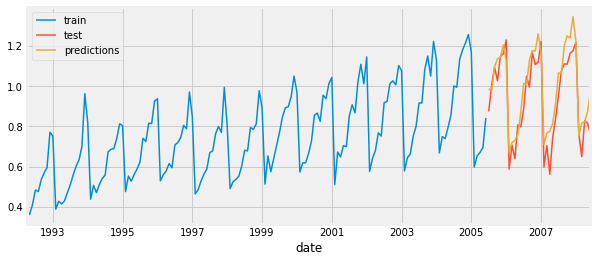

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['y'].plot(ax=ax, label='train')
data_test['y'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['y'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 0.009726551142140267


### Prediction intervals

A prediction interval defines the interval within which the true value of  𝑦  is expected to be found with a given probability.

Rob J Hyndman and George Athanasopoulos, list in their book Forecasting: Principles and Practice [multiple ways to estimate prediction intervals](https://otexts.com/fpp2/prediction-intervals.html), most of which require that the residuals (errors) of the model are distributed in a normal way. When this property cannot be assumed, bootstrapping can be resorted to, which only assumes that the residuals are uncorrelated. This is the method used in the Skforecast library for the ForecasterAutoreg and ForecasterAutoregCustom type models.

### Get Data:

In [ ]:
# Data download
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
data_raw = pd.read_csv(url, sep=',')

### Data Prep:

In [ ]:
# Data preparation
# ==============================================================================
data = data_raw.copy()
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y/%m/%d')
data = data.set_index('date')
data = data.rename(columns={'x': 'y'})
data = data.asfreq('MS')
data = data.sort_index()

### Split Data

In [ ]:
# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

### Create Forecasters and Train Forecaster

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
                )

forecaster.fit(y=data_train['y'])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
              )

predictions.head(5)

,pred,lower_bound,upper_bound
2005-07-01,0.962317,0.836348,1.072365
2005-08-01,0.976595,0.786105,1.093848
2005-09-01,1.140783,0.976097,1.262243
2005-10-01,1.179538,1.009499,1.306744
2005-11-01,1.221138,1.059447,1.348892


### Prediction Error Graph

Test error (mse): 0.01053658052670281


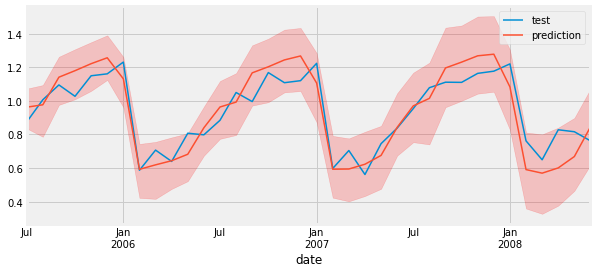

In [ ]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['y'],
                y_pred = predictions.iloc[:, 0]
            )
print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_test['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='prediction')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

### Backtest

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00

Test error (mse): 0.01053658052670281


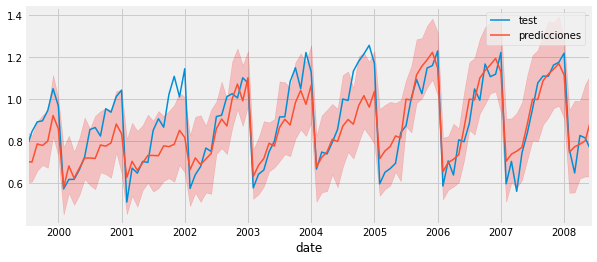

In [ ]:
# Backtest with prediction intervals
# ==============================================================================
n_val = 36*3
data_train = data[:-n_val]
data_val  = data[-n_val:]

steps = 36
forecaster = ForecasterAutoreg(
                regressor = make_pipeline(StandardScaler(), Lasso(alpha=0.0215)),
                lags = 15
            )

metric, predictions = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = data['y'],
                            initial_train_size = len(data_train),
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            verbose            = True
                       )

print(f"Test error (mse): {error_mse}")

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_val['y'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predictions.index,
    predictions['lower_bound'],
    predictions['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

### Forecasting models in production

A trained model may be deployed in production in order to generate predictions regularly. Suppose predictions have to be generated on a weekly basis, for example, every Monday. By default, when using the predict method on a trained forecaster object, predictions start right after the last training observation. Therefore, the model could be retrained weekly, just before the first prediction is needed, and call its predict method. This strategy, although simple, may not be possible to use for several reasons:

Model training is very expensive and cannot be run as often.

The history with which the model was trained is no longer available.

The prediction frequency is so high that there is no time to train the model between predictions.

In these scenarios, the model must be able to predict at any time, even if it has not been recently trained.

Every model generated using skforecast has the last_window argument in its predict method. Using this argument, it is possible to provide only the past values needs to create the autoregressive predictors (lags) and thus, generate the predictions without the need to retrain the model.

In [ ]:
data_train['y'].tail()

date
1999-02-01    0.512696
1999-03-01    0.652996
1999-04-01    0.573976
1999-05-01    0.639238
1999-06-01    0.703872
Freq: MS, Name: y, dtype: float64

In [ ]:
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(),
                    lags = 5
                )

forecaster.fit(y=data_train['y'])

In [ ]:
forecaster.predict(steps=3)

1999-07-01    0.745856
1999-08-01    0.779587
1999-09-01    0.789505
Freq: MS, Name: pred, dtype: float64

As expected, predictions follow directly from the end of training data.

When last_window is provided, the forecaster uses this data to generate the lags needed as predictors and starts the prediction afterwards.

In [ ]:
forecaster.predict(steps=3, last_window=data['y'].tail(5))

2008-07-01    0.775895
2008-08-01    0.796205
2008-09-01    0.726692
Freq: MS, Name: pred, dtype: float64

Since the provided last_window contains values from 2008-02-01 to 2008-06-01, the forecaster is able to create the needed lags and predict the next 5 steps.

⚠ WARNING:
It is important to note that the lenght of last windows must be enought to include the maximum lag used by the forecaster. Fore example, if the forecaster uses lags 1, 24, 48, last_window must include the last 72 values of the series.

### Load and save models

[Skforecast](https://joaquinamatrodrigo.github.io/skforecast/) models can be loaded and stored using pickle or joblib libraries. A simple example using joblib is shown below.

In [ ]:
# Create forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=data_train['y'])
forecaster.predict(steps=3)

1999-07-01    0.781417
1999-08-01    0.798413
1999-09-01    0.811728
Freq: MS, Name: pred, dtype: float64

In [ ]:
# Save model
dump(forecaster, filename='time_series_forecasting_saved_model1.py')

['time_series_forecasting_saved_model1.py']

In [ ]:
# Load model
forecaster_loaded = load('time_series_forecasting_saved_model1.py')

In [ ]:
# Predict
forecaster_loaded.predict(steps=3)

1999-07-01    0.781417
1999-08-01    0.798413
1999-09-01    0.811728
Freq: MS, Name: pred, dtype: float64

### Session info

In [ ]:
session_info.show(html=False)

-----
google              NA
joblib              1.1.0
matplotlib          3.2.2
numpy               1.21.5
pandas              1.3.5
session_info        1.0.0
skforecast          0.4.3.dev2
sklearn             1.0.2
-----
IPython             5.5.0
jupyter_client      5.3.5
jupyter_core        4.9.1
notebook            5.3.1
-----
Python 3.7.12 (default, Jan 15 2022, 18:48:18) [GCC 7.5.0]
Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
-----
Session information updated at 2022-02-20 17:54
